In [85]:
import pandas as pd
import numpy as np
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, RobustScaler, MinMaxScaler

In [100]:
df = pd.read_csv("../data/cleaned-scientometrics-and-bibliometrics-research.csv", low_memory=False)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50027 entries, 0 to 50026
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  50027 non-null  object 
 1   publication_year       50027 non-null  int64  
 2   cited_by_count         50027 non-null  int64  
 3   topics.display_name    50027 non-null  object 
 4   topics.score           50027 non-null  object 
 5   cited_by_count_norm    50027 non-null  float64
 6   publication_year_norm  50027 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 2.7+ MB


In [102]:
df['topics.display_name'] = df['topics.display_name'].apply(lambda x: ast.literal_eval(x))
df['topics.score'] = df['topics.score'].apply(lambda x: ast.literal_eval(x))

In [103]:
df

,title,publication_year,cited_by_count,topics.display_name,topics.score,cited_by_count_norm,publication_year_norm
0,How to conduct a bibliometric analysis: An ove...,2021,6635,[scientometrics and bibliometrics research],[0.9736],1.000000,0.996341
1,Analyzing the past to prepare for the future: ...,2002,6002,"[scientometrics and bibliometrics research, De...","[0.8112, 0.8084, 0.7988]",0.987637,0.978037
2,Co‐citation in the scientific literature: A ne...,1973,4591,[scientometrics and bibliometrics research],[0.9994],0.954593,0.946613
3,"Comparison of PubMed, Scopus, Web of Science, ...",2007,3769,"[scientometrics and bibliometrics research, Bi...","[0.9943, 0.9924, 0.9793]",0.930270,0.983010
4,The journal coverage of Web of Science and Sco...,2015,3167,"[scientometrics and bibliometrics research, Ac...","[0.9994, 0.9448, 0.9224]",0.908817,0.990731
...,...,...,...,...,...,...,...
50022,Issue Publication Information,2018,0,[scientometrics and bibliometrics research],[0.5676],0.000000,0.993555
50023,W. A. TAYLOR and CO.,1961,0,"[scientometrics and bibliometrics research, Ir...","[0.8668, 0.8155, 0.7664]",0.000000,0.932099
50024,VARIAN associates,1962,0,"[scientometrics and bibliometrics research, In...","[0.2804, 0.2517]",0.000000,0.933348
50025,scientific products,1963,0,[scientometrics and bibliometrics research],[0.315],0.000000,0.934589


In [104]:
def pad_topic_list(topics, max_len=3, pad_token="<PAD>"):
    pad_length = max_len - len(topics)
    if pad_length > 0:
        topics.extend([pad_token] * pad_length)
    return topics

def pad_score_list(scores, max_len=3, pad_value=0.0):
    pad_length = max_len - len(scores)
    if pad_length > 0:
        scores.extend([pad_token] * pad_length)
    return scores

df['topics.display_name'] = df['topics.display_name'].apply(lambda x: pad_topic_list(x, max_len=3, pad_token="<PAD>"))
df['topics.score'] = df['topics.score'].apply(lambda x: pad_topic_list(x, max_len=3, pad_token=0.0))

In [105]:
topic_to_index = {topic: idx for idx, topic in enumerate(sorted(set(df['topics.display_name'].explode().unique())))}

In [106]:
def topics_to_indices(topics_list, mapping):
    """
    Converts a list of topic strings to a list of indices using the provided mapping.
    If a topic is not found, it defaults to the padding index.
    """
    return [mapping.get(topic, mapping["<PAD>"]) for topic in topics_list]
    
df['topics.indices'] = df['topics.display_name'].apply(lambda topics: topics_to_indices(topics, topic_to_index))

In [107]:
df

,title,publication_year,cited_by_count,topics.display_name,topics.score,cited_by_count_norm,publication_year_norm,topics.indices
0,How to conduct a bibliometric analysis: An ove...,2021,6635,"[scientometrics and bibliometrics research, <P...","[0.9736, 0.0, 0.0]",1.000000,0.996341,"[829, 1, 1]"
1,Analyzing the past to prepare for the future: ...,2002,6002,"[scientometrics and bibliometrics research, De...","[0.8112, 0.8084, 0.7988]",0.987637,0.978037,"[829, 211, 788]"
2,Co‐citation in the scientific literature: A ne...,1973,4591,"[scientometrics and bibliometrics research, <P...","[0.9994, 0.0, 0.0]",0.954593,0.946613,"[829, 1, 1]"
3,"Comparison of PubMed, Scopus, Web of Science, ...",2007,3769,"[scientometrics and bibliometrics research, Bi...","[0.9943, 0.9924, 0.9793]",0.930270,0.983010,"[829, 88, 725]"
4,The journal coverage of Web of Science and Sco...,2015,3167,"[scientometrics and bibliometrics research, Ac...","[0.9994, 0.9448, 0.9224]",0.908817,0.990731,"[829, 4, 821]"
...,...,...,...,...,...,...,...,...
50022,Issue Publication Information,2018,0,"[scientometrics and bibliometrics research, <P...","[0.5676, 0.0, 0.0]",0.000000,0.993555,"[829, 1, 1]"
50023,W. A. TAYLOR and CO.,1961,0,"[scientometrics and bibliometrics research, Ir...","[0.8668, 0.8155, 0.7664]",0.000000,0.932099,"[829, 490, 431]"
50024,VARIAN associates,1962,0,"[scientometrics and bibliometrics research, In...","[0.2804, 0.2517, 0.0]",0.000000,0.933348,"[829, 474, 1]"
50025,scientific products,1963,0,"[scientometrics and bibliometrics research, <P...","[0.315, 0.0, 0.0]",0.000000,0.934589,"[829, 1, 1]"


In [108]:
class PaperEmbeddingModule(nn.Module):
    def __init__(self, num_topics, embedding_dim, topic_output_dim, pad_idx, numeric_feature_dim, final_dim):
        """
        Args:
            num_topics (int): Total number of unique topics.
            embedding_dim (int): Dimensionality of each learnable topic embedding.
            topic_output_dim (int): Intermediate dimension for the aggregated topic representation.
            pad_idx (int): The index for the padding token "<PAD>".
            numeric_feature_dim (int): Number of numeric features (e.g., 2 for publication_year and cited_by_count).
            final_dim (int): Desired dimensionality of the final fused paper embedding.
        """
        super(PaperEmbeddingModule, self).__init__()
        
        # Topic embedding branch.
        self.topic_embedding = nn.Embedding(num_topics, embedding_dim, padding_idx=pad_idx)
        # Transform the aggregated topic vector to an intermediate topic representation.
        self.topic_mlp = nn.Sequential(
            nn.Linear(embedding_dim, topic_output_dim),
            nn.ReLU()
        )
        
        # Numeric branch: project publication_year and cited_by_count into the same space.
        self.numeric_projection = nn.Sequential(
            nn.Linear(numeric_feature_dim, topic_output_dim),
            nn.ReLU()
        )
        
        # Fusion layer: Combine topic and numeric representations.
        self.fusion_layer = nn.Sequential(
            nn.Linear(topic_output_dim * 2, final_dim),
            nn.ReLU()
        )
        
    def forward(self, topic_indices, topic_scores, numeric_features):
        """
        Args:
            topic_indices (LongTensor): Shape [batch_size, num_topics_per_paper] with padded topic indices.
            topic_scores (Tensor): Shape [batch_size, num_topics_per_paper] with topic relevance scores.
            numeric_features (Tensor): Shape [batch_size, numeric_feature_dim] with numeric features 
                                       (e.g., [publication_year, cited_by_count]).
        Returns:
            output (Tensor): Final paper embedding of shape [batch_size, final_dim].
        """
        # --- Topic Branch ---
        # Look up topic embeddings: shape [batch_size, num_topics_per_paper, embedding_dim]
        embeddings = self.topic_embedding(topic_indices)
        # Multiply each topic's embedding by its score.
        topic_scores_expanded = topic_scores.unsqueeze(-1)
        weighted_embeddings = embeddings * topic_scores_expanded
        # Sum across the topic dimension.
        weighted_sum = weighted_embeddings.sum(dim=1)
        # Normalize by sum of scores (avoid division by zero with small constant).
        sum_scores = topic_scores.sum(dim=1, keepdim=True) + 1e-8
        aggregated_topic = weighted_sum / sum_scores  # shape: [batch_size, embedding_dim]
        # Project to topic_output_dim.
        topic_repr = self.topic_mlp(aggregated_topic)   # shape: [batch_size, topic_output_dim]
        
        # --- Numeric Branch ---
        # numeric_features should be preprocessed externally. Here we assume a shape [batch_size, numeric_feature_dim].
        numeric_repr = self.numeric_projection(numeric_features)  # shape: [batch_size, topic_output_dim]
        
        # --- Fusion ---
        # Concatenate the representations along feature dimension.
        combined = torch.cat([topic_repr, numeric_repr], dim=1)     # shape: [batch_size, topic_output_dim * 2]
        final_embedding = self.fusion_layer(combined)                # shape: [batch_size, final_dim]
        return final_embedding

In [124]:
num_topics = len(topic_to_index)   # Suppose we have 100 unique topics in the dataset.
embedding_dim = 64                 # Each topic is represented by a 64-dimensional vector.
topic_output_dim = 128             # Intermediate representation dimension for the topic branch.
final_dim = 256                    # Final paper embedding dimension.
pad_idx = topic_to_index["<PAD>"]
numeric_feature_dim = 2            # We use two numeric features: publication_year and cited_by_count

# Instantiate the module.
model = PaperEmbeddingModule(num_topics, embedding_dim, topic_output_dim, pad_idx,
                             numeric_feature_dim, final_dim)

# Randomly pick 20 papers
sample_df = df.sample(n=20, random_state=42).reset_index(drop=True)

topic_tensor = torch.tensor(sample_df['topics.indices'].tolist(), dtype=torch.long)
scores_tensor = torch.tensor(sample_df['topics.score'].tolist(), dtype=torch.float)
publication_year = torch.tensor(np.array(sample_df['publication_year'].tolist(), dtype=np.float32)).unsqueeze(1)
cited_by_count = torch.tensor(np.array(sample_df['cited_by_count'].tolist(), dtype=np.float32)).unsqueeze(1)
numeric_features = torch.cat([publication_year, cited_by_count], dim=1)


# Forward pass to obtain the aggregated topic embedding for each paper.
final_embeddings = model(topic_tensor, scores_tensor, numeric_features)
print("Final Paper Embeddings Shape:", final_embeddings.shape)
print("Final Paper Embeddings:\n", final_embeddings)

Final Paper Embeddings Shape: torch.Size([20, 256])
Final Paper Embeddings:
 tensor([[  0.0000,  69.5772,   0.0000,  ..., 280.0041,  83.7574,   0.0000],
        [  0.0000,  73.2050,   0.0000,  ..., 281.8152,  83.9897,   0.0000],
        [  0.0000,  72.0290,   0.0000,  ..., 280.1835,  83.3954,   0.0000],
        ...,
        [  0.0000,  72.6707,   0.0000,  ..., 280.3799,  83.5843,   0.0000],
        [  0.0000,  72.9154,   0.0000,  ..., 280.7005,  83.6588,   0.0000],
        [  0.0000,  70.5982,   0.0000,  ..., 271.7821,  81.0120,   0.0000]],
       grad_fn=<ReluBackward0>)


In [125]:
sample_df[['topics.indices', 'topics.score', 'publication_year', 'publication_year_norm', 'cited_by_count', 'cited_by_count_norm']]

,topics.indices,topics.score,publication_year,publication_year_norm,cited_by_count,cited_by_count_norm
0,"[829, 164, 760]","[0.9968, 0.9777, 0.9527]",2018,0.993555,20,0.295771
1,"[829, 1, 1]","[0.0681, 0.0, 0.0]",2024,0.999091,0,0.000000
2,"[829, 554, 5]","[0.9988, 0.9968, 0.9956]",2014,0.989781,5,0.154523
3,"[829, 1, 1]","[0.8082, 0.0, 0.0]",1973,0.946613,1,0.050013
4,"[829, 1, 1]","[0.9929, 0.0, 0.0]",2019,0.994488,2,0.085497
5,"[829, 1, 1]","[0.1907, 0.0, 0.0]",2023,0.998179,0,0.000000
6,"[829, 1, 1]","[0.9378, 0.0, 0.0]",2015,0.990731,0,0.000000
7,"[829, 1, 1]","[0.1016, 0.0, 0.0]",1955,0.924448,4,0.135510
8,"[829, 1, 1]","[0.3691, 0.0, 0.0]",1920,0.873243,0,0.000000
9,"[829, 703, 4]","[0.9989, 0.9544, 0.9181]",2016,0.991677,3,0.113021


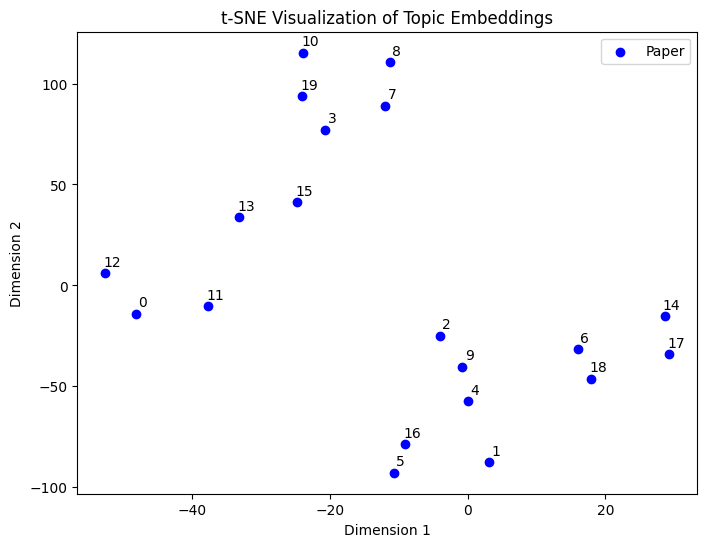

In [126]:
from sklearn.manifold import TSNE

embeddings_np = final_embeddings.detach().cpu().numpy()
tsne = TSNE(n_components=2, random_state=42, perplexity=5, max_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings_np)

plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', label='Paper')

for idx, (x, y) in enumerate(embeddings_2d):
    plt.annotate(str(idx), (x, y), textcoords="offset points", xytext=(5,5), ha='center')

plt.title("t-SNE Visualization of Topic Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [133]:
df.iloc[[3]]

,title,publication_year,cited_by_count,topics.display_name,topics.score,cited_by_count_norm,publication_year_norm,topics.indices
3,"Comparison of PubMed, Scopus, Web of Science, ...",2007,3769,"[scientometrics and bibliometrics research, Bi...","[0.9943, 0.9924, 0.9793]",0.93027,0.98301,"[829, 88, 725]"
